# Equispaced Demo on the $\mathbb T^2$

load libraries and reset random number generator

In [1]:
using Plots, LinearAlgebra, Random
push!(LOAD_PATH, "..")
using FCV
rng = MersenneTwister(7);

## Initialization

In [2]:
d = 2 # dimension
N = 2^10 # number of nodes
M = N # number of frequencies
s = 3 # degree of sobolev weights
What = [ abs(norm(freq)+1).^s for freq in Iterators.product(ntuple(x -> -N/2:N/2-1, d)...) ] |> vec;

generate sample function values 

In [3]:
function peaks(x, y) # peaks sample function from matlab
  x *= 6
  y *= 6
  z = 3*(1-x)^2*exp(-(x^2) - (y+1)^2) -
    10*(x/5 - x^3 - y^5)*exp(-x^2-y^2) -
    1/3*exp(-(x+1)^2 - y^2) 
  return z
end
fun = (x, y) -> peaks(x, y)
nodes = Iterators.product(ntuple(x -> (-N/2:N/2-1)/N, d)...)
f = [ fun(n...) for n in nodes ] |> vec;

add noise and create `FCV` object

In [4]:
sigma = 0.1
f_e = f+sigma*(maximum(f)-minimum(f))*randn(rng, size(f))

@time fcv = fcv_t_equispaced(d, f_e);

  3.145199 seconds (3.59 M allocations: 232.198 MiB, 3.18% gc time)


## Computations

compute the cross-validation score and the error for frequency weigths of the form `lambda` times `What` for different values of lambda

In [5]:
lambda = [ exp(t) for t in range(-12,-6, length = 25) ]
cv = similar(lambda)
l2err = similar(lambda)

@time for i in eachindex(lambda)
    res = compute(fcv, lambda[i]*What)
    cv[i] = res.gcv
    l2err[i] = 1/M*norm(f-res.f_r)
end

res = compute(fcv, lambda[argmin(cv)]*What);

  5.005034 seconds (4.13 M allocations: 4.890 GiB, 8.21% gc time)


## Plotting

plot the cross-validation score against the actual $L_2$-error

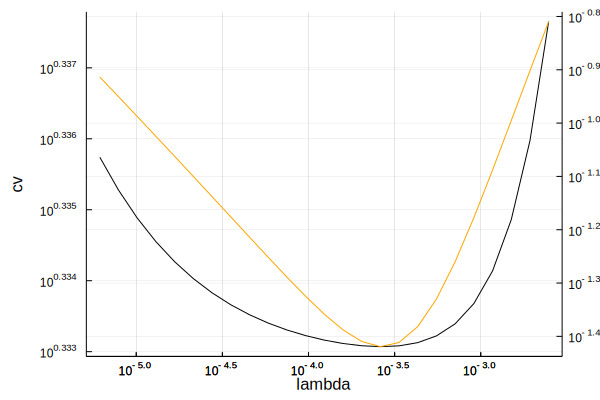

In [6]:
plot(lambda, cv,
  color = :black,
  axis = (:log10),
  xlabel = "lambda",
  ylabel = "cv",
  legend = :none)
plot!(twinx(), lambda, l2err,
  color = :orange,
  legend = :none,
  axis = (:log10),
  ylabel = "l2err",
  guidefontcolor = :orange)

plot the noisy data against the reconstruction with frequency weights corresponding to the minimal cross-validation score

In [7]:
p_noisy = heatmap(
(-N/2:N/2-1)/N,
(-N/2:N/2-1)/N,
reshape(f_e, N, N),
title = "noisy data",
aspect_ratio = :equal,
clims = (minimum(f), maximum(f)))

p_reconstruction = heatmap(
(-N/2:N/2-1)/N,
(-N/2:N/2-1)/N,
reshape(real(res.f_r), N, N),
title = "reconstruction",
aspect_ratio = :equal,
clims = (minimum(f), maximum(f)))

plot(p_noisy, p_reconstruction)